# SimVP Dataset

> dataset for SimVP

In [68]:
#| default_exp simvp_dataset

In [69]:
#| export
from torch.utils.data import Dataset
import torch
import os
from torchvision import transforms
from maskpredformer.vis_utils import show_video_line

In [70]:
#| export
DEFAULT_DATA_PATH = "/home/enes/dev/maskpredformer/data/DL"

In [71]:
#| export
class DLDataset(Dataset):
    def __init__(self, root, mode):
        self.mask_path = os.path.join(root, f"{mode}_masks.pt")
        self.mode = mode
        print("INFO: Loading masks from", self.mask_path)
        self.masks = torch.load(self.mask_path)
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
        ])

    def __len__(self):
        return self.masks.shape[0]
    
    def __getitem__(self, idx):
        if self.mode == "train":
            ep = self.transform(self.masks[idx])
        else:
            ep = self.masks[idx]
        data = ep[:11].long()
        labels = ep[11:].long()
        return data, labels

**Test dataset**

In [72]:
dataset = DLDataset('../data/DL', 'val')

INFO: Loading masks from ../data/DL/val_masks.pt


In [73]:
x, y = dataset[0]

In [74]:
x.shape, y.shape

(torch.Size([11, 160, 240]), torch.Size([11, 160, 240]))

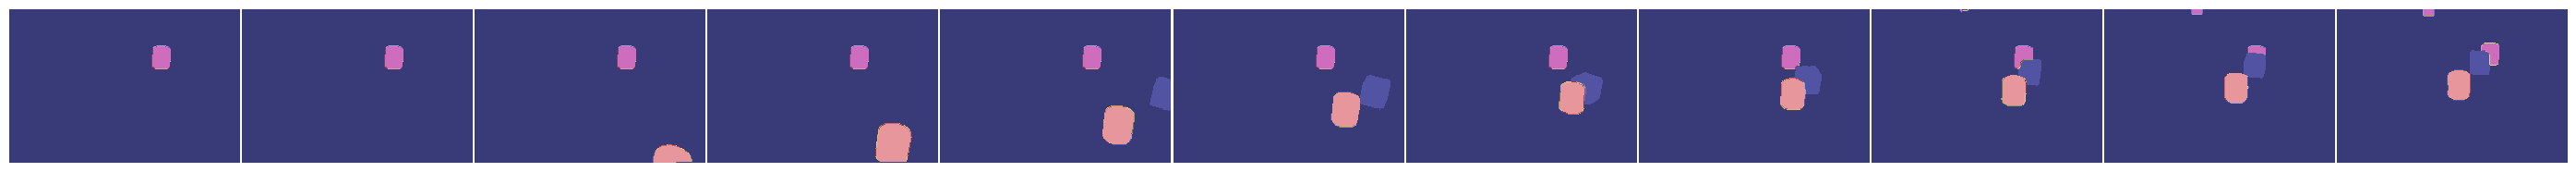

In [75]:
show_video_line(x, len(x))

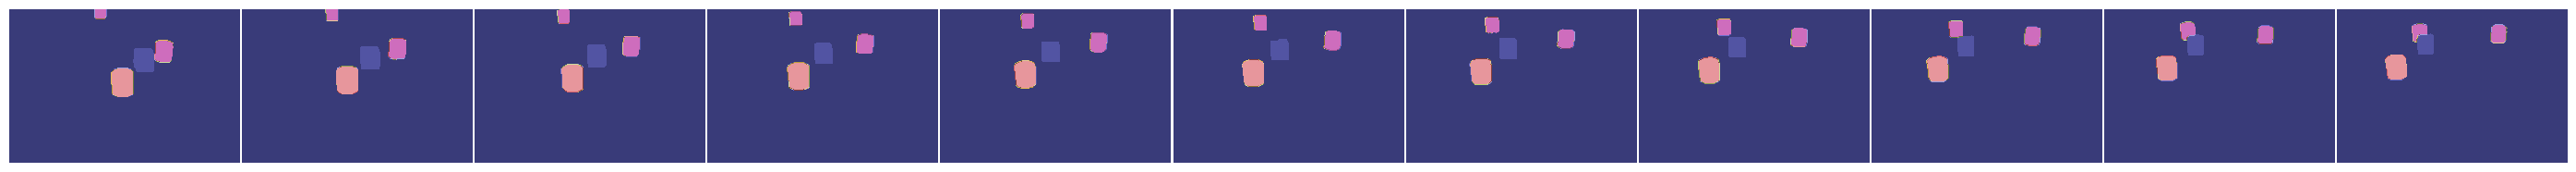

In [76]:
show_video_line(y, len(y))

In [77]:
#| hide
import nbdev; nbdev.nbdev_export()